In [17]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
from metpy.units import units, pandas_dataframe_to_unit_arrays
from metpy.plots import SkewT
import metpy.calc as mpcalc
from siphon.simplewebservice.wyoming import WyomingUpperAir


In [4]:
#set date and station
date = datetime(2004, 6, 12, 12)


#dt = datetime.strptime(date, '%Y%m%d')

station = input('Input station id')
#station=input('Station id:')

df = WyomingUpperAir.request_data(date, station)


initial data


In [6]:
print('initial data')
df

initial data


,pressure,height,temperature,dewpoint,direction,speed,u_wind,v_wind,station,station_number,time,latitude,longitude,elevation
0,968.0,387,22.4,21.2,200.0,5.0,1.710101,4.698463e+00,SGF,72440,2004-06-12 12:00:00,37.23,-93.38,387.0
1,948.0,572,23.6,21.1,229.0,23.0,17.358320,1.508936e+01,SGF,72440,2004-06-12 12:00:00,37.23,-93.38,387.0
2,943.9,610,23.4,20.9,235.0,27.0,22.117105,1.548656e+01,SGF,72440,2004-06-12 12:00:00,37.23,-93.38,387.0
3,925.0,789,22.4,20.0,240.0,27.0,23.382686,1.350000e+01,SGF,72440,2004-06-12 12:00:00,37.23,-93.38,387.0
4,911.8,914,21.7,19.4,250.0,25.0,23.492316,8.550504e+00,SGF,72440,2004-06-12 12:00:00,37.23,-93.38,387.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84,5.8,35052,-32.8,-63.4,90.0,33.0,-33.000000,-2.020667e-15,SGF,72440,2004-06-12 12:00:00,37.23,-93.38,387.0
85,5.0,36120,-25.1,-58.1,70.0,34.0,-31.949549,-1.162868e+01,SGF,72440,2004-06-12 12:00:00,37.23,-93.38,387.0
86,4.8,36418,-23.3,-57.3,63.0,35.0,-31.185228,-1.588967e+01,SGF,72440,2004-06-12 12:00:00,37.23,-93.38,387.0
87,4.7,36576,-24.0,-57.6,60.0,35.0,-30.310889,-1.750000e+01,SGF,72440,2004-06-12 12:00:00,37.23,-93.38,387.0


In [7]:
#add in appropiate units

data = pandas_dataframe_to_unit_arrays(df)
#print(data_with_units)

subset_to_100 = data['pressure'] >= 100 * units.hPa

# Subset pressure and read in other data to only 100 mb
p = data['pressure']
height = data['height']
T = data['temperature']
Td = data['dewpoint']
u = data['u_wind']
v = data['v_wind']
deg = data['direction']
spd = data['speed']
#print(df.units)

In [11]:
#compute variables

#potential temp
pot = mpcalc.potential_temperature(p, T)

#relative humidity
rh = mpcalc.relative_humidity_from_dewpoint(T, Td)

#mixing ratio
mix = mpcalc.mixing_ratio_from_relative_humidity(rh, T, p)

#calculate path and levels from parcel

prof = (mpcalc.parcel_profile(p, T[0], Td[0])).to('degC')

#LCL
lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])

#LFC
lfc_pressure, lfc_temperature = mpcalc.lfc(p, T, Td, which='top')

#EL
el_pressure, el_temperature = mpcalc.el(p, T, Td, which='top')

#SBCAPE and SBCIN
cape, cin = mpcalc.cape_cin(p, T, Td, prof)


In [12]:
#calculate LI
def lifted_index(T,prof):
    '''this function calculates the lifted index.
    
       inputs:
       T = temperature
       prof = profile
       
       outputs: lifted_index'''
    
    tenv = T[np.where(p.m==500)]
    tpar = prof[np.where(p.m==500)]
    lifted_index = tenv-tpar
    return lifted_index[0]

li=lifted_index(T,prof).m

print(li)

-5.768463927053869


In [13]:
#calculate TT
def total_totals(T,Td):
    
    '''This is a function to calculate the total totals.
    
       inputs:
       T=temperature
       td=dew point
       
       outputs:
       total totals'''
    
    t850 = T[np.where(p.m ==850)]
    t500 = T[np.where(p.m ==500)]
    td850 = Td[np.where(p.m ==850)]
    vt = t850 -t500
    ct = td850 - t500
    
    total_totals = vt + ct
    return total_totals[0]

tt = total_totals(T,Td).m

print(tt)

54.199999999999996


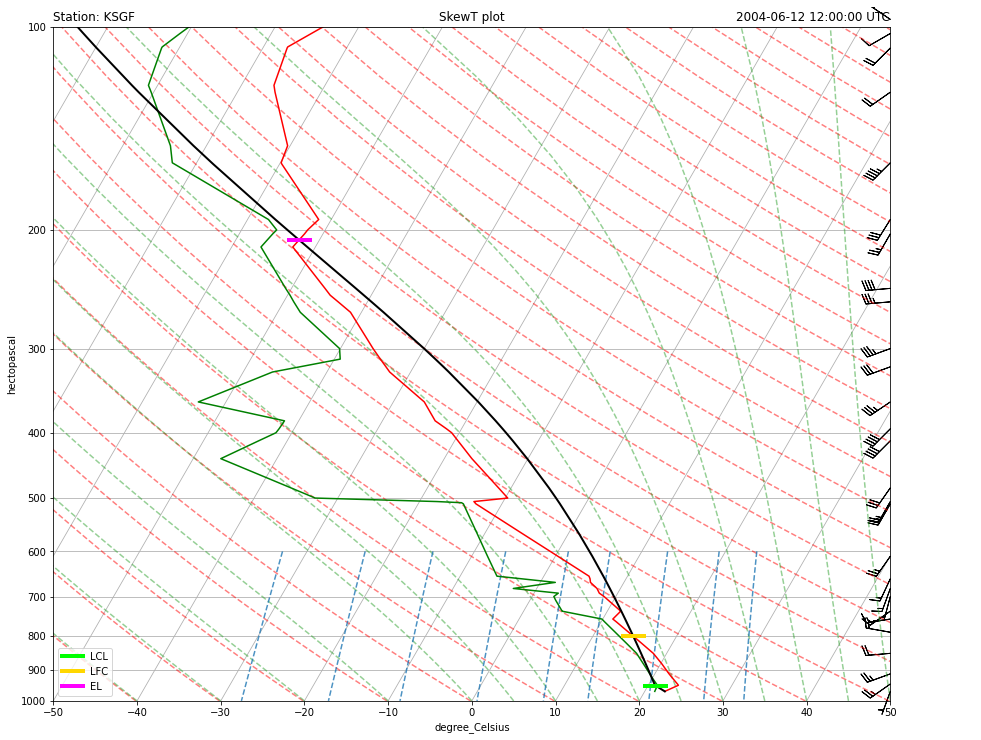

In [15]:
#plot sounding
fig = plt.figure(figsize=(15, 15))

skew = SkewT(fig)

skew.plot(p, T, 'r')
skew.plot(p, Td, 'g')

# Plot barbs skipping to every other barb
skew.plot_barbs(p[::2], u[::2], v[::2], y_clip_radius=0.03)

# Set sensible axis limits
skew.ax.set_ylim(1000, 100)
skew.ax.set_xlim(-50, 50)

# Plot the skew-T parcel temperature profile
skew.plot(p, prof, 'k', linewidth=2)

# Plot a line marker at the LCL/LFC/EL level
skew.plot(lcl_pressure, lcl_temperature, 'k_', markersize=25, 
          markeredgewidth=4, color='lime', label='LCL')
skew.plot(lfc_pressure, lfc_temperature, 'k_', markersize=25, 
          markeredgewidth=4, color='gold', label='LFC')
skew.plot(el_pressure, el_temperature, 'k_', markersize=25, 
          markeredgewidth=4, color='magenta', label='EL')

# Add the relevant special lines
skew.plot_dry_adiabats(t0=np.arange(233,555,10)*units.K)
skew.plot_moist_adiabats(color='tab:green')
skew.plot_mixing_lines(color='tab:blue')

# Plot titles
plt.title('Station: K{}'.format(station), loc='left')
plt.title('SkewT plot', loc='center')
plt.title('{} UTC'.format(date), loc='right')


plt.legend(loc='lower left')

# Show the plot
plt.show()
